In [170]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from importlib import reload  # Python 3.4+

from sklearn import metrics
from sklearn.inspection import permutation_importance

import lightgbm as lgb

import seaborn as sns
sns.set()

from sklearn.calibration import CalibratedClassifierCV

from IPython.display import clear_output, display

In [194]:
train_df = pd.read_csv('train_processed_data_for_2012.csv')
train_df.shape

(837913, 75)

In [195]:
test_df = pd.read_csv('test_processed_data_for_2012.csv')
test_df.shape

(1025045, 74)

In [205]:
train_df.columns[train_df.columns.str.contains('sector')]

Index(['ateco_sector'], dtype='object')

In [8]:
train_df['stmt_date'] = pd.to_datetime(train_df['stmt_date'])
train_df['def_date'] = pd.to_datetime(train_df['def_date'])
train_df.sort_values('stmt_date', inplace=True)

test_df['stmt_date'] = pd.to_datetime(test_df['stmt_date'])
test_df['def_date'] = pd.to_datetime(test_df['def_date'])
test_df.sort_values('stmt_date', inplace=True)

## Train algorithm

In [11]:
### features for first firm
features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    # 'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    # 'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    'roe_quantile_values',
    # 'ebitda',
]


In [31]:
### features for recurring firms
rec_features = [
    'asst_tot_quantile_values',
    'financial_leverage_quantile_values',
    'profitability_ratio_quantile_values',
    'net_income_growth_quantile_values',
    'quick_ratio_v2_quantile_values',
    'sales_growth_quantile_values',
    'cash_assets_ratio_quantile_values',
    'dscr_quantile_values',
    'roe_quantile_values',
    # 'ebitda',

]

In [13]:
formula = 'default ~ '+' + '.join(features)
#formula = 'default ~ '+' + '.join(rec_features)
formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + quick_ratio_v2_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile_values'

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [161]:
# model = RandomForestClassifier(max_depth=8, n_estimators=150, oob_score=metrics.roc_auc_score, bootstrap=True)

In [171]:
model = 'lgbm'

In [162]:
algo = smf.probit
model = algo(formula, data = train_df) 

In [172]:
if 'sklearn' in str(type(model)):
    model_type = 'sklearn'
elif model == 'lgbm':
    model_type = 'lgbm'
elif 'statsmodel' in str(type(model)):
    model_type = 'stats'
else:
    raise ("Model type not recognized")

## Training

In [164]:
# from sklearn_inspect import Inspector

In [173]:
# train_data = lgb.Dataset(train_df[features], label=train_df['default'])
# validation_data = lgb.Dataset(test_df[features], label=test_df['default'], reference=train_data)
# param = {'num_leaves': 31, 'objective': 'binary'}
# param['metric'] = 'auc'

# num_round = 50
# bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

# ypred = bst.predict(test_df[features])

In [165]:
if model_type == 'sklearn':
    X = train_df[features]
    y = train_df['default']
    fitted_model = model.fit(X, y)
    
    result = permutation_importance(fitted_model, X, y, n_repeats=5, random_state=42)
    # Summarize results
    for i in result.importances_mean.argsort()[::-1]:
        print(f"{X.columns[i]}: Mean={result.importances_mean[i]:.4f}, Std={result.importances_std[i]:.4f}")

elif

elif model_type == 'stats':
    fitted_model = model.fit()
    print(fitted_model.summary())
    print(fitted_model.get_margeff().summary())

Optimization terminated successfully.
         Current function value: 0.048469
         Iterations 9
                          Probit Regression Results                           
Dep. Variable:                default   No. Observations:               226234
Model:                         Probit   Df Residuals:                   226227
Method:                           MLE   Df Model:                            6
Date:                Mon, 11 Nov 2024   Pseudo R-squ.:                  0.2022
Time:                        20:12:41   Log-Likelihood:                -10965.
converged:                       True   LL-Null:                       -13745.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.7332      0.090 

## Process test data

In [166]:
if model_type == 'sklearn':
    test_X = test_df[features]
    test_y = test_df['default']
    
    test_predictions = fitted_model.predict_proba(test_X)[:,1]

elif model_type == 'stats':
    test_predictions = fitted_model.predict(test_df)

test_results = test_df[['default']].copy()
test_results['predictions'] = test_predictions
metrics.roc_auc_score(y_score=test_results['predictions'], y_true=test_results['default'])

np.float64(0.8213539187657071)

ROC AUC 0.8213539187657071


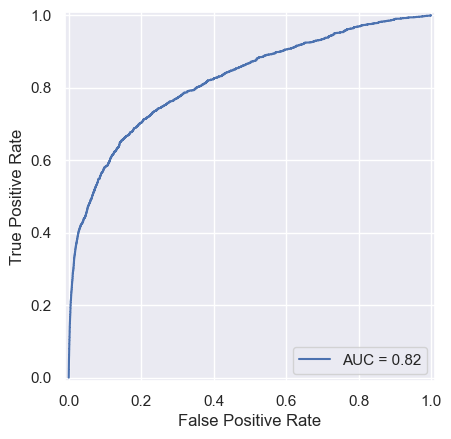

In [167]:
fpr, tpr, thresholds = metrics.roc_curve(test_results['default'], test_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

## Process train data

In [168]:
if model_type == 'sklearn':
    train_preds = fitted_model.predict_proba(X)[:,1]

elif model_type == 'stats':
    train_preds = fitted_model.predict(train_df)

train_results = train_df[['default']].copy()
train_results['predictions'] = train_preds
metrics.roc_auc_score(y_score=train_results['predictions'], y_true=train_results['default'])

np.float64(0.8344395625816867)

ROC AUC 0.8344395625816867


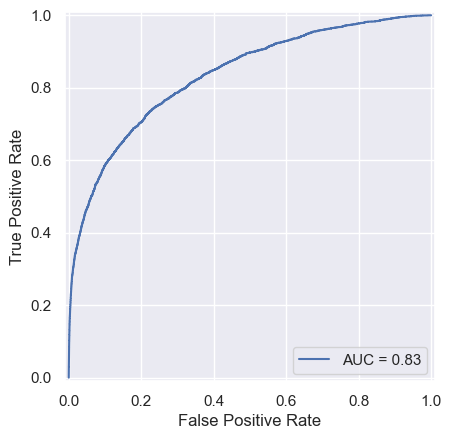

In [169]:
fpr, tpr, thresholds = metrics.roc_curve(train_results['default'], train_results['predictions'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()